<a href="https://colab.research.google.com/github/stephenadhi/nn-mpc/blob/main/data_generation/decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.executable
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from pandas import DataFrame
from pandas import read_csv
import math
from numpy import savetxt
from scipy.integrate import odeint, RK45
from tensorflow.keras.utils import plot_model
import timeit


## Mass-Spring-System


In [ ]:
# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x1, v1, x2, v2, x3, v3 = w
    m, k, kp, d, u1, u2, dist = p

    # Create f = (x1',y1',x2',y2'):
    f = [v1,
         (k * ((-2 * x1) + x2) + kp * (-x1 ** 3 + (x2 - x1) ** 3) + d * (v2-2*v1)) / m + u1,
         v2,
         (k * (x1 - (2 * x2) + x3) + kp * ((x3 - x2) ** 3 - (x2 - x1) ** 3) + d * (v1-2*v2+v3)) / m + u2,
         v3,
         (k * (x2 - x3) + kp * ((x2 - x3) ** 3) + d* (v2-v3)) / m + dist]
    return f

# Generate Data considering mass decay - The algorithm does not work for this case, because Dynamics change in every time step is too extreme. Instead, the dynamics is only changed once for the experiment later - at 22 seconds

In [ ]:
num_rollouts= 1
# Masses:
m = 0.5 
decay= 1e-7
# Spring constants
kp = 63.5
k = 217.0
#damping constant
d= 0.15
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

num_data= 40003
interval= 0.001
stoptime = interval*(num_data)
np.random.seed(28)
hist= np.zeros((1,15))

for roll in range(1):
    act1= 2000*(np.random.rand(num_data)-0.5)
    act2= 2000*(np.random.rand(num_data)-0.5)
    dist = 1000*(np.random.rand(num_data)-0.5)
    #Initial states
    w0= np.zeros((1,6))
    #w0 = np.random.randn(1,6) 
    w0= w0.flatten()
    prev = [[w0[0],w0[2],w0[4]]]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, d, act1[0], act2[0], dist[0]]
    # Call the ODE solver.
    t1= np.array([0,interval])
    wsol1 = odeint(vectorfield, w0, t1, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    prevv= prev
    prev = [[w0[0],w0[2],w0[4]]]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, d, act1[1], dist[1], act2[1]]
    # Call the ODE solver.
    t2= np.array([0+interval,interval+interval])
    wsol1 = odeint(vectorfield, w0, t2, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    curr = np.hstack((prevv, prev, np.array([[act1[1]]]),np.array([[dist[1]]]),np.array([[act2[1]]]),wcurr))
    hist= np.vstack((hist, curr))
   
    lag=2
    for ts in range(num_data-lag):
        prevv = prev
        t = np.array([stoptime * float(ts+lag) / (num_data), stoptime * float(ts + lag + 1) / (num_data)])
        mdec= m*np.exp(1)**(-decay*ts)
        p = [mdec, k, kp, d, act1[ts+lag],  dist[ts+lag], act2[ts+lag]]
        # Call the ODE solver.
        wsol1 = odeint(vectorfield, w0, t, args=(p,),
            atol=abserr, rtol=relerr)
        wsol1 = wsol1.flatten()
        w0 = wsol1[6:]
        prev = np.array([[wsol1[0],wsol1[2],wsol1[4]]])
        action= [act1[ts+lag],act2[ts+lag]]
        new = np.hstack((prevv,prev,np.array([[act1[ts+lag]]]),np.array([[dist[ts+lag]]]),np.array([[act2[ts+lag]]]),np.array([w0])))
        hist = np.vstack((hist, new))
hist=pd.DataFrame(data=hist,columns =["prev11", "prev22","prev33","prev1","prev2","prev3","u1","dist.","u2","x1", "v1", "x2", "v2", "x3", "v3"])
df=hist[1:][{"u1","dist.","u2","prev11","prev22","prev33","prev1","prev2","prev3","x1", "v1", "x2", "v2", "x3", "v3"}]
df = df[['u1','dist.','u2',"prev11","prev22","prev33","prev1","prev2","prev3",'x1','v1','x2','v2','x3','v3']]
print(mdec)
df

0.49800399467199574


,u1,dist.,u2,prev11,prev22,prev33,prev1,prev2,prev3,x1,v1,x2,v2,x3,v3
1,122.479205,-3.898106,-751.475956,0.000000,0.000000,0.000000,0.000229,-0.000140,-0.000239,0.000748,0.579309,-0.000421,-0.282952,-0.001092,-1.228536
2,-750.065816,212.706552,-643.119160,0.000229,-0.000140,-0.000239,0.000748,-0.000421,-0.001092,0.000951,-0.171952,-0.000597,-0.070477,-0.002641,-1.870685
3,-204.815263,229.098389,336.689348,0.000748,-0.000421,-0.001092,0.000951,-0.000597,-0.002641,0.000676,-0.377568,-0.000554,0.157351,-0.004343,-1.532203
4,562.616413,-105.952925,518.336748,0.000951,-0.000597,-0.002641,0.000676,-0.000554,-0.004343,0.000580,0.184418,-0.000451,0.049427,-0.005615,-1.011488
5,21.985963,7.694679,604.333827,0.000676,-0.000554,-0.004343,0.000580,-0.000451,-0.005615,0.000775,0.205532,-0.000398,0.054986,-0.006323,-0.404498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39998,901.713640,3.936139,-505.015130,1.675745,2.968418,3.569451,1.703955,2.993169,3.580928,1.732512,28.717128,3.017351,23.905161,3.592068,10.750936
39999,-598.657590,-61.611155,-479.281738,1.703955,2.993169,3.580928,1.732512,3.017351,3.592068,1.760622,27.495882,3.040946,23.284012,3.602445,10.004702
40000,-765.675771,-421.396184,71.896448,1.732512,3.017351,3.592068,1.760622,3.040946,3.602445,1.787402,26.059149,3.063738,22.300229,3.612355,9.816844
40001,-507.813636,136.225710,-249.191133,1.760622,3.040946,3.602445,1.787402,3.063738,3.612355,1.812851,24.833693,3.085823,21.870945,3.621920,9.314752


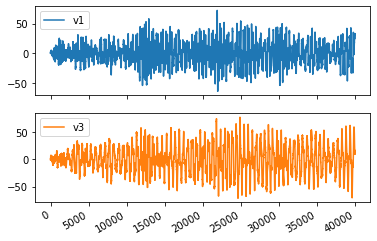

In [ ]:
plot_cols = ['v1', 'v3']
plot_features = hist[plot_cols][:]
_ = plot_features.plot(subplots=True)

In [ ]:
NN_in= df[{"u1","u2","dist."}]
NN_in= NN_in[['u1','dist.','u2']].shift(-1)
NN_label= df[{"x1", "x3"}]
NN_label= NN_label[ ["x1", "x3"] ]
NN_previous= df[{"prev11","prev33","prev1","prev3"}]
NN_previous= NN_previous[ ["prev11","prev33"] ]
diff1= df["x1"] - df["prev1"]
diff3= df["x3"] - df["prev3"]
diff21= df["x1"] - df["prev11"]
diff23= df["x3"] - df["prev33"]
df.insert(7, "diff21", diff21)
df.insert(8, "diff23", diff23)
df.insert(9, "diff1", diff1)
df.insert(10, "diff3", diff3)
bothdiff= df[["diff1","diff3"]].shift(0)
bothdiff2= df[["diff21","diff23"]].shift(0)
frames = [NN_in,bothdiff2, NN_label, NN_previous, bothdiff]
df = pd.concat(frames, axis=1)
#x1_ = df[{'x1'}]
#x3_ = df[{'x3'}]
#prev111 = x1_.shift(3)
#prev333 = x3_.shift(3)
#prev1111 = x1_.shift(4)
#prev3333 = x3_.shift(4)
#df.insert(3,"prev1111",prev1111)
#df.insert(4,"prev3333",prev3333)
#df.insert(3,"prev111",prev111)
#df.insert(4,"prev333",prev333)
#diff31= df["x1"] - df["prev111"]
#diff33= df["x3"] - df["prev333"]
#df=df.drop(columns=["prev111","prev333"])
#df.insert(3, "diff31", diff31)
#df.insert(4, "diff33", diff33)
af=df.dropna()
df= af[ ["u1","dist.","u2", "x1", "x3","diff21","diff23","diff1","diff3"] ]
df

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
1,-750.065816,212.706552,-643.119160,0.000748,-0.001092,0.000748,-0.001092,0.000519,-0.000853
2,-204.815263,229.098389,336.689348,0.000951,-0.002641,0.000722,-0.002403,0.000204,-0.001550
3,562.616413,-105.952925,518.336748,0.000676,-0.004343,-0.000071,-0.003251,-0.000275,-0.001702
4,21.985963,7.694679,604.333827,0.000580,-0.005615,-0.000371,-0.002973,-0.000097,-0.001272
5,-634.613283,347.221089,761.646884,0.000775,-0.006323,0.000098,-0.001980,0.000195,-0.000708
...,...,...,...,...,...,...,...,...,...
39997,901.713640,3.936139,-505.015130,1.703955,3.580928,0.056336,0.023223,0.028210,0.011477
39998,-598.657590,-61.611155,-479.281738,1.732512,3.592068,0.056767,0.022617,0.028556,0.011140
39999,-765.675771,-421.396184,71.896448,1.760622,3.602445,0.056666,0.021517,0.028110,0.010377
40000,-507.813636,136.225710,-249.191133,1.787402,3.612355,0.054890,0.020287,0.026780,0.009910


In [ ]:
ww= df[0:40000]
ww.to_csv('decay1000damptestdata40k_0.001ssim.csv',index=False)


# Plotting New vs. Old Dynamics at 22 - 40 seconds

In [ ]:
bbb= pd.read_csv('1611changemassdist100changerefreinf_startsim40000_train500-250_batch16sim300-1000-1000-pen5.csv')
aaa= pd.read_csv('1611dist100changerefreinf_startsim40000_train500-250_batch16sim300-1000-1000-pen5.csv')

<Figure size 576x216 with 0 Axes>

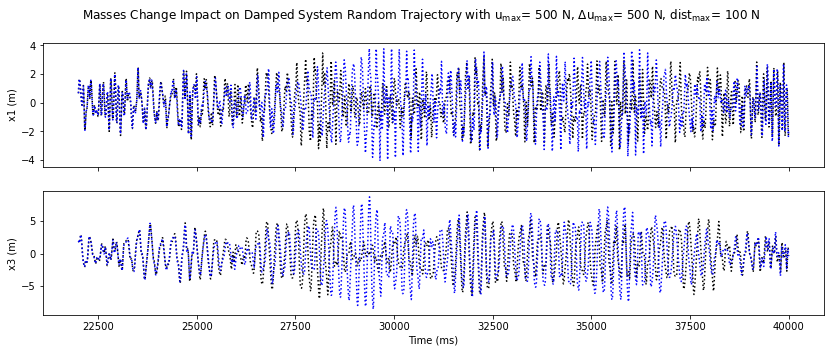

In [ ]:
plt.figure(figsize=(8,3))
fig, axs = plt.subplots(2, sharex=True,figsize=(14,5))
x= range(22000,40000)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
y=aaa.iloc[22000:40000,3].values
z=aaa.iloc[22000:40000,4].values
c=bbb.iloc[22000:40000,3].values
d=bbb.iloc[22000:40000,4].values
fig.suptitle('Masses Change Impact on Damped System Random Trajectory with $u_{max}$= 500 N, $\Delta$$u_{max}$= 500 N, dist$_{max}$= 100 N')
axs[0].plot(x, y, 'k:')
axs[0].plot(x, c, 'b:')
axs[1].plot(x, z, 'k:')
axs[1].plot(x, d, 'b:')
axs[0].set_ylabel("x1 (m)") 
axs[1].set_ylabel("x3 (m)") 
axs[1].set_xlabel("Time (ms)") 
#axs[0].set_title("Position (m)") 
#axs[0].plot(range(5000), aaa.iloc[:,3].values, 'B')
plt.savefig('nodisteffectchangemass22.png', dpi=300)

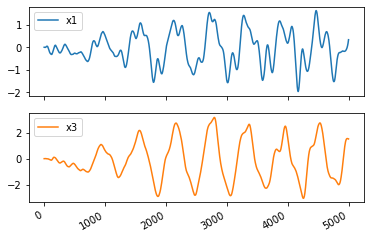

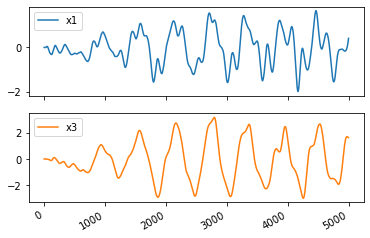

In [ ]:
#max(df[{'diff1'}].values)
plot_out= ['x1','x3']
plot_features = aaa[plot_out][1:5000]
_ = plot_features.plot(subplots=True)
plot_features = ww[plot_out][1:5000]
_ = plot_features.plot(subplots=True)